### test for plotting pft level data on h1 files
Created by Will Wieder
Improved by Orhan Eroglu
March 2025

In [1]:
import os, sys
import shutil
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import xarray as xr
import xesmf as xe

# Helpful for plotting only
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import uxarray as ux  #need npl 2024a or later
import geoviews.feature as gf

print(ux.__version__)
#sys.path.append('/glade/u/home/wwieder/python/adf/lib/plotting_functions.py')

2025.3.0


In [2]:
# Load datataset
# TODO, develop function for this too
gppfile='/glade/derecho/scratch/wwieder/ADF/b.e30_beta04.BLT1850.ne30_t232_wgx3.121/climo/b.e30_beta04.BLT1850.ne30_t232_wgx3.121_GPP_climo.nc'
h0_file='/glade/derecho/scratch/wwieder/archive/ctsm5.4_5.3.068_PPEcal115_116_HIST/lnd/hist/ctsm5.4_5.3.068_PPEcal115_116_HIST.clm2.h0a.1930-11.nc'
#laih1file='/glade/derecho/scratch/wwieder/ctsm53n04ctsm52028_ne30pg3t232_hist.clm2.h1.TLAI.1860s.nc'
laih1file='/glade/derecho/scratch/wwieder/TLAI_cat/ctsm5.4_5.3.068_PPEcal115_116_HIST.clm2.h1a.TLAI.1850s.nc'
case = 'ctsm5.4_5.3.068_PPEcal115_116_HIST'

mesh0 = '/glade/campaign/cesm/cesmdata/inputdata/share/meshes/ne30pg3_ESMFmesh_cdf5_c20211018.nc'

#ux file for plotting
uxds0 = ux.open_dataset(mesh0, h0_file).max('time')
uxds1 = ux.open_dataset(mesh0, laih1file).max('time')

# Assign coords to uxds0, which will be needed later for align() operation
n_face_coords = np.arange(1,(uxds1.pfts1d_ixy.max().astype(int)+1))
uxds0 = uxds0.assign_coords({'n_face': ('n_face', n_face_coords)})


In [15]:
def reshape_ux_h1(uxds1, uxds0, var, npft=15):
    """
    Reshape unstructured data from h1 history files:
        - Inputs 1d data from uxarray dataset (pft) into
        - Returns 2d uxarray dataset (pft x n_face)
        - Also include area + landfrac data, taken here from h0 dataset

    Requires h1 and h0 datasets that include the target variable
    By default this function only runs on the native pfts

    """

    for i in range(1, npft):
        temp = uxds1.where(uxds1.pfts1d_itype_veg==i, drop=True)
        # TODO, PFT weights should be time evolving, but they aren't here
        # Rename coord, since the pft dimension is not meaningful
        temp= temp.rename({'pft': 'n_face'})

        # assign values from pfts1d_ixy to n_face
        temp['n_face'] = temp.pfts1d_ixy.astype(int)
        temp.assign_coords({"npft": i})

        # combine along PFT variable
        if i == 1:
            uxdsOut = temp
        else:
            uxdsOut = xr.concat([uxdsOut, temp], dim="npft")
    
    uxdsOut.uxgrid = temp.uxgrid
    uxdsOut, _ = xr.align(uxdsOut, uxds0[var], join="right")
    # now copy over area & landfrac
    uxdsOut['area'] = uxds0.area
    uxdsOut['landfrac'] = uxds0.landfrac
    return uxdsOut

In [17]:
# Call the reshape_ux_h1 function
npft=15
var='TLAI'
uxdsOut = reshape_ux_h1(uxds1, uxds0, var, npft)

<xarray.UxDataset> Size: 91MB
Dimensions:             (n_face: 48600, npft: 14, nbnd: 2)
Coordinates:
  * n_face              (n_face) int64 389kB 1 2 3 4 ... 48597 48598 48599 48600
Dimensions without coordinates: npft, nbnd
Data variables: (12/18)
    time_bounds         (npft, nbnd, n_face) object 11MB nan ... 1860-01-01 0...
    pfts1d_lon          (npft, n_face) float64 5MB nan nan nan ... 136.0 135.0
    pfts1d_lat          (npft, n_face) float64 5MB nan nan nan ... 36.2 35.74
    pfts1d_ixy          (npft, n_face) float64 5MB nan nan ... 4.86e+04 4.86e+04
    pfts1d_jxy          (npft, n_face) float64 5MB nan nan nan ... 1.0 1.0 1.0
    pfts1d_gi           (npft, n_face) float64 5MB nan nan ... 1.596e+04
    ...                  ...
    pfts1d_wtgcell      (npft, n_face) float64 5MB nan nan ... 0.02033 0.01889
    pfts1d_wtlunit      (npft, n_face) float64 5MB nan nan ... 0.02151 0.0193
    pfts1d_wtcol        (npft, n_face) float64 5MB nan nan ... 0.02151 0.0193
    TLAI                (npft, n_face) float32 3MB nan nan ... 0.4011 0.03994
    area                (n_face) float32 194kB nan nan ... 9.519e+03 9.519e+03
    landfrac            (n_face) float32 194kB nan nan nan ... 0.2991 0.07713

In [9]:
# Read in pft names
pft_constants = xr.open_dataset(
    '/glade/campaign/cesm/cesmdata/cseg/inputdata/lnd/clm2/paramdata/ctsm60_params.c241017.nc')
pft_names = pft_constants.pftname

'''
Or hard code them
pft_names = ['NET Temperate', 'NET Boreal', 'NDT Boreal',
             'BET Tropical', 'BET Temperate', 'BDT Tropical',
             'BDT Temperate', 'BDT Boreal', 'BES Temperate',
             'BDS Temperate', 'BDS Boreal', 'C3 Grass Arctic',
             'C3 Grass', 'C4 Grass', 'UCrop UIrr']
'''

-- wrote pft TLAI figure --


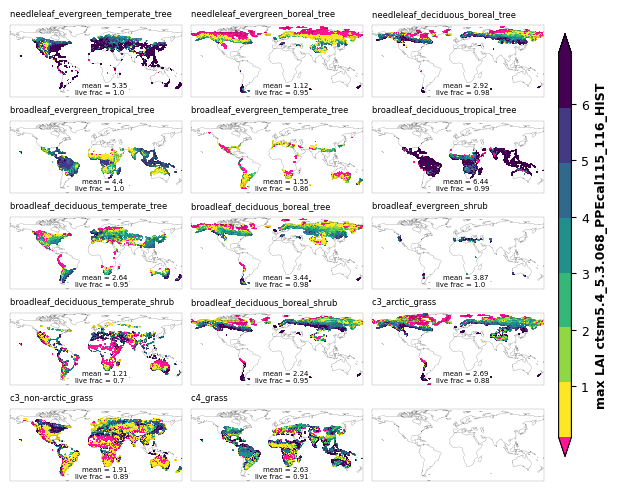

In [14]:
transform = ccrs.PlateCarree()
proj = ccrs.PlateCarree()
cmap = plt.cm.viridis_r
cmap.set_under(color='deeppink')
cmap = cmap.resampled(7)
levels = [0.1, 1, 2, 3, 4, 5, 6, 7]

# create figure object
fig, axs = plt.subplots(5,3,
    facecolor="w",
    constrained_layout=True,
    subplot_kw=dict(projection=proj) )

axs=axs.flatten()

# Loop over pfts
for i in range((npft-1)):
    ac = uxdsOut[var].isel(npft=i).to_polycollection(projection=proj)
    ac.set_cmap(cmap)
    ac.set_antialiased(False)
    ac.set_transform(transform)
    ac.set_clim(vmin=0.1,vmax=6.9)
    axs[i].add_collection(ac)

    #Titles, statistics
    wgts = uxdsOut.area * uxdsOut.landfrac * uxdsOut.pfts1d_wtgcell.isel(npft=i)
    wgts = wgts / wgts.sum()
    mean = str(np.round((uxdsOut[var].isel(npft=i)*wgts).sum().values,2))
    dead = ((uxdsOut[var].isel(npft=i)<0.1)*wgts).sum()
    live = ((uxdsOut[var].isel(npft=i)>0.1)*wgts).sum()
    livefrac = str(np.round((live/(live+dead)).values,2))
    axs[i].set_title(str(pft_names[(1+i)].data)[2:40], loc='left',size=6)
    axs[i].text(-30, -45,'mean = '+ mean, fontsize=5)
    axs[i].text(-45, -60,'live frac = '+livefrac,fontsize=5)

for a in axs:
    a.coastlines().set_linewidth(0.1)
    a.set_global()
    a.spines['geo'].set_linewidth(0.1) #cartopy's recommended method
    a.set_extent([-180, 180, -65, 86])

fig.set_layout_engine("compressed")
cbar_ax = fig.add_axes([0.94, 0.06, 0.02, 0.88])
cbar = fig.colorbar(ac, cax=cbar_ax, pad=0.1, shrink=0.7, aspect=40, extend='both')
cbar.ax.tick_params(labelsize=9)
cbar.set_label(label=("max LAI "+case), size=9, weight='bold')

fig.savefig('h1_test', bbox_inches='tight', dpi=300)
print('-- wrote pft '+var+' figure --')
plt.show() ;